In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import xesmf as xe
import requests
import pandas as pd
import cartopy.feature as feature
from scipy.stats import ttest_ind
import scipy.stats as stats

In [2]:
df_pdo = pd.read_excel('pdo.xlsx')

print(df_pdo.head())

                   time   PDO
0  1950-01-01T00:00:00Z -1.78
1  1950-02-01T00:00:00Z -2.20
2  1950-03-01T00:00:00Z -1.75
3  1950-04-01T00:00:00Z -1.73
4  1950-05-01T00:00:00Z -2.83


In [3]:
df_pdo

,time,PDO
0,1950-01-01T00:00:00Z,-1.78
1,1950-02-01T00:00:00Z,-2.20
2,1950-03-01T00:00:00Z,-1.75
3,1950-04-01T00:00:00Z,-1.73
4,1950-05-01T00:00:00Z,-2.83
...,...,...
892,2024-05-01T00:00:00Z,-2.16
893,2024-06-01T00:00:00Z,-2.42
894,2024-07-01T00:00:00Z,-1.97
895,2024-08-01T00:00:00Z,-1.88


In [4]:
df_pdo['time'] = pd.to_datetime(df_pdo['time'])  # Convert time to datetime format

# Create an xarray Dataset
ds_pdo = xr.Dataset(
    {
        'PDO': ('time', df_pdo['PDO'].values)
    },
    coords={
        'time': df_pdo['time'].values
    }
)

# Save to NetCDF file
#ds_pdo.to_netcdf('pdo_data.nc')

In [5]:
ds_pdo

<xarray.Dataset>
Dimensions:  (time: 897)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2024-09-01
Data variables:
    PDO      (time) float64 -1.78 -2.2 -1.75 -1.73 ... -2.42 -1.97 -1.88 -2.63

In [6]:
ds_pdo['time']

<xarray.DataArray 'time' (time: 897)>
array(['1950-01-01T00:00:00.000000000', '1950-02-01T00:00:00.000000000',
       '1950-03-01T00:00:00.000000000', ..., '2024-07-01T00:00:00.000000000',
       '2024-08-01T00:00:00.000000000', '2024-09-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2024-09-01

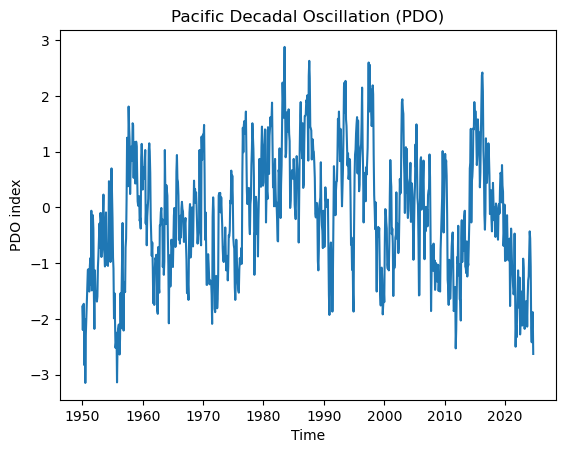

In [7]:
plt.plot(ds_pdo['time'],ds_pdo['PDO']) ;
plt.title('Pacific Decadal Oscillation (PDO)')
plt.xlabel('Time')
plt.ylabel('PDO index')
plt.show()

## The tos file

In [8]:
model_file = 'tos_Omon_IPSL-CM6A-LR_historical_r12i1p1f1_gn_185001-201412.nc'
df = xr.open_dataset(model_file)
df

/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/backends/plugins.py:65: RuntimeWarning: Engine 'gini' loading failed:
cannot import name 'deprecated' from 'typing_extensions' (/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/typing_extensions.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:         (y: 332, x: 362, nvertex: 4, time: 1980, axis_nbounds: 2)
Coordinates:
    nav_lat         (y, x) float32 ...
    nav_lon         (y, x) float32 ...
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T...
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    bounds_nav_lon  (y, x, nvertex) float32 ...
    bounds_nav_lat  (y, x, nvertex) float32 ...
    area            (y, x) float32 ...
    time_bounds     (time, axis_nbounds) datetime64[ns] ...
    tos             (time, y, x) float32 ...
Attributes: (12/50)
    name:                   /ccc/work/cont003/gencmip6/p86denv/IGCM_OUT/IPSLC...
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-08-10T18:47:49Z
    tracking_id:            hdl:21.14100/4799a67f-5401-44ab-9727-5bd41f99d2d5
    description:            CMIP6 historical
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / CM...
    ...                     ...
    EXPID:                  historical
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    dr2xml_md5sum:          523ab9c7b70cfe3bc2c825d1e555e1d0
    model_version:          6.1.5
    parent_variant_label:   r1i1p1f1
    history:                Tue Sep  4 11:11:09 2018: ncatted -O -a parent_va...

In [9]:
new_lat=np.arange(-90,90.5,0.5)
new_lon=np.arange(0,360.1,0.1)

ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                    'lon': (['lon'], new_lon)
                    })
ds_out

<xarray.Dataset>
Dimensions:  (lat: 361, lon: 3601)
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9 360.0
Data variables:
    *empty*

In [10]:
regridder = xe.Regridder(df, ds_out,'bilinear', ignore_degenerate=True)
dr_out = regridder(df['tos']).to_dataset(name='tos')
dr_out

<xarray.Dataset>
Dimensions:  (time: 1980, lat: 361, lon: 3601)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9 360.0
Data variables:
    tos      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan

In [11]:
ds_tos = dr_out.tos.sel(time=slice(ds_pdo['time'][0],dr_out['time'][-1]))
ds_tos

<xarray.DataArray 'tos' (time: 780, lat: 361, lon: 3601)>
array([[[ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        ...,
        [-1.7321715, -1.7321216, -1.7320715, ..., -1.7322712,
         -1.7322214, -1.7321715],
        [-1.7299619, -1.7299392, -1.7299166, ..., -1.730007 ,
         -1.7299844, -1.7299619],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
...
        [-1.5954351, -1.5955389, -1.5956426, ..., -1.5952275,
         -1.5953313, -1.5954351],
        [-1.5864569, -1.5865113, -1.5865656, ..., -1.586348 ,
         -1.5864025, -1.5864569],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        ...,
        [-1.6279181, -1.6279998, -1.6280816, ..., -1.6277546,
         -1.6278363, -1.6279181],
        [-1.6265458, -1.6265905, -1.6266351, ..., -1.6264565,
         -1.6265012, -1.6265458],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9 360.0
Attributes:
    regrid_method:  bilinear

In [12]:
ds_pdo = ds_pdo.sel(time=slice(ds_pdo['time'][0], dr_out['time'][-1]))
ds_pdo = ds_pdo.reset_coords(drop=False) 

In [13]:
ds_pdo

<xarray.Dataset>
Dimensions:  (time: 780)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2014-12-01
Data variables:
    PDO      (time) float64 -1.78 -2.2 -1.75 -1.73 -2.83 ... 0.74 1.42 1.4 1.89

## Defining Positive and Negative PDO
PDO >= 0 -> Positive phase

PDO < 0 -> Negative phase

In [14]:
Positive = ds_pdo['PDO'].where(ds_pdo['PDO']>=0) 
Negative = ds_pdo['PDO'].where(ds_pdo['PDO']<0)


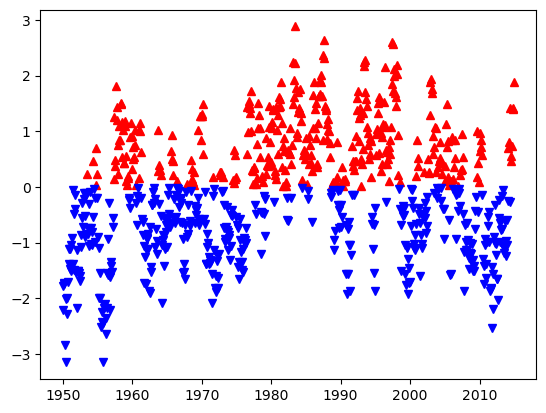

In [15]:
plt.plot(ds_pdo['time'],Positive,'r^')
plt.plot(ds_pdo['time'],Negative,'bv')

In [16]:
print('Positive: ',Positive.count(dim='time').values)
print('Negative: ',Negative.count(dim='time').values)

counts=[Positive.count(dim='time').values,
        Negative.count(dim='time').values]
print(counts)

Positive:  361
Negative:  419
[array(361), array(419)]


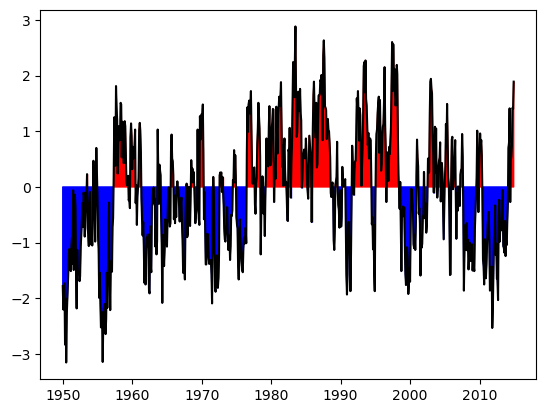

In [17]:
plt.plot(ds_pdo['time'],ds_pdo['PDO'],'k')
#plt.fill_between(ds_pdo['time'].values,ds_pdo['PDO'],color='lightgreen')
plt.fill_between(ds_pdo['time'].values,Positive,color='red')
plt.fill_between(ds_pdo['time'].values,Negative,color='blue')
#plt.axhline(0,color='black',linewidth=0.5)
#plt.axhline(1,color='black',linewidth=0.5,linestyle='dotted')
#plt.axhline(-1,color='black',linewidth=0.5,linestyle='dotted') ;

## finding the right time range

In [18]:
dr_out

<xarray.Dataset>
Dimensions:  (time: 1980, lat: 361, lon: 3601)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9 360.0
Data variables:
    tos      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan

In [19]:
ds_pdo['time']

<xarray.DataArray 'time' (time: 780)>
array(['1950-01-01T00:00:00.000000000', '1950-02-01T00:00:00.000000000',
       '1950-03-01T00:00:00.000000000', ..., '2014-10-01T00:00:00.000000000',
       '2014-11-01T00:00:00.000000000', '2014-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2014-12-01

In [20]:
da_climo = ds_tos.groupby('time.month').mean()
da_anoms = ds_tos.groupby('time.month')-da_climo
da_anoms

<xarray.DataArray 'tos' (time: 780, lat: 361, lon: 3601)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.06084764, -0.06078041, -0.06071305, ..., -0.06098175,
         -0.06091475, -0.06084764],
        [-0.06570435, -0.06567383, -0.06564355, ..., -0.06576514,
         -0.06573451, -0.06570435],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
...
        [ 0.0311718 ,  0.03108513,  0.03099871, ...,  0.03134549,
          0.03125882,  0.0311718 ],
        [ 0.03371036,  0.03366482,  0.03362012, ...,  0.03380072,
          0.0337553 ,  0.03371036],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.02248192,  0.0224191 ,  0.02235615, ...,  0.02260804,
          0.0225451 ,  0.02248192],
        [ 0.0170244 ,  0.01698875,  0.01695275, ...,  0.01709616,
          0.01706016,  0.0170244 ],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9 360.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [21]:
### Matching the time
da_anoms['time'] = pd.to_datetime(da_anoms['time'].values).normalize()
Positive['time'] = pd.to_datetime(Positive['time'].values).normalize()

In [23]:
# Use nearest selection to align dates
PositivePDO_tos = da_anoms.sel(time=Positive.dropna(dim='time')['time'], method="nearest").mean(dim='time')
NegativePDO_tos = da_anoms.sel(time=Negative.dropna(dim='time')['time'], method="nearest").mean(dim='time')

comp_tos = [PositivePDO_tos, NegativePDO_tos]

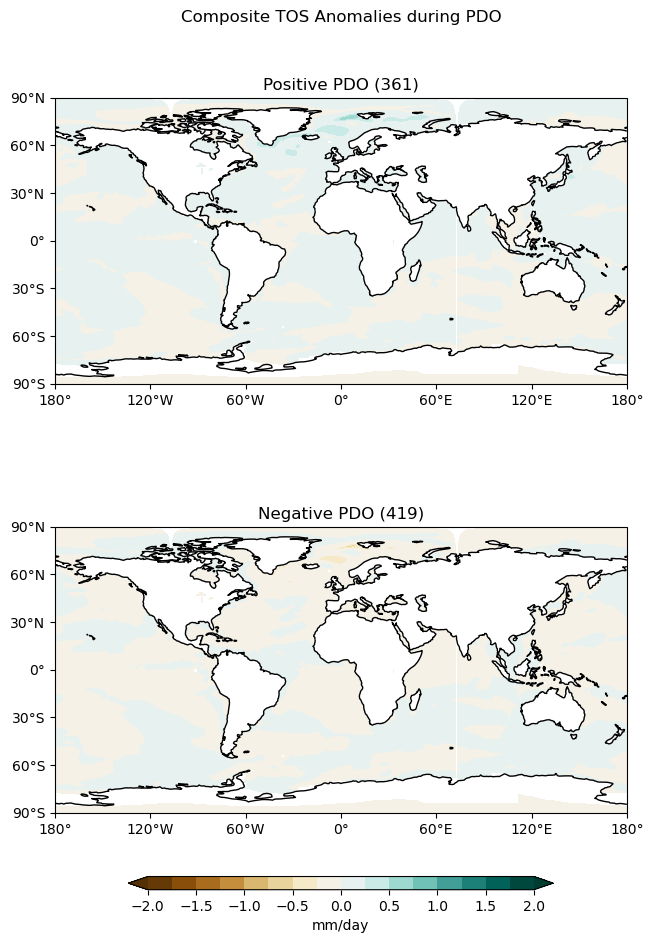

In [25]:
labels=['Positive PDO','Negative PDO']
clevs = np.arange(-2.0,2.1,0.25)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array (just 3 rows)
axs = axs.flatten()

#Loop over all of the seasons and plot
for i,pdo in enumerate(comp_tos):

        # Select the season
        data = comp_tos[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data,coord=comp_tos[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,comp_tos[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i]+' ('+str(counts[i])+')')

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm/day')

# Add a big title at the top
plt.suptitle('Composite TOS Anomalies during PDO') ;

### Significance Testing


In [26]:
diff_tos =PositivePDO_tos - NegativePDO_tos

# plot our difference map

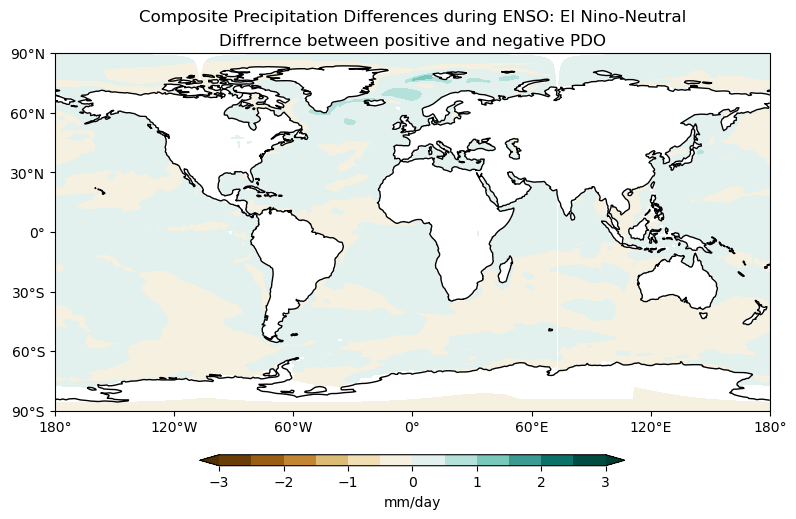

In [27]:
label = 'Diffrernce between positive and negative PDO'
clevs = np.arange(-3, 3.5, 0.5)

# Define the figure and the single axis
fig, ax = plt.subplots(nrows=1, ncols=1,
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(8.5, 5.5))

# Select the data for "El Nino-Neutral"
data = diff_tos

# Add the cyclic point for continuity in the plot
data, lons = add_cyclic_point(data, coord=diff_tos['lon'])

# Contour plot
cs = ax.contourf(lons, diff_tos['lat'], data, clevs,
                 transform=ccrs.PlateCarree(),
                 cmap='BrBG', extend='both')

# Longitude labels
ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Title for the plot
ax.set_title(label)

# Draw coastlines
ax.coastlines()

# Adjust the layout for colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.15, 0.5, 0.02])
fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', label='mm/day')

# Add a big title at the top
plt.suptitle('Composite Precipitation Differences during ENSO: El Nino-Neutral')

plt.show()

In [28]:
p = 0.05

# show data is normally distributed

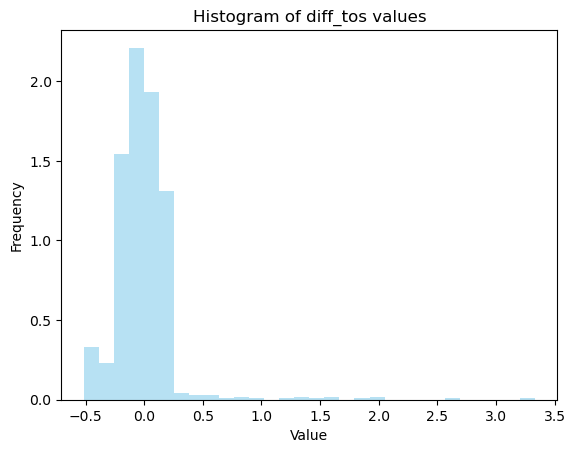

In [38]:

selected_point = da_anoms.sel(lat=89.0, lon=45.0, method="nearest")
#plt.figure(figsize=(3, 2))
#plt.plot(selected_point)
plt.hist(selected_point, bins=30, density=True, alpha=0.6, color='skyblue')
plt.title("Histogram of diff_tos values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [30]:
diff_tos

<xarray.DataArray 'tos' (lat: 361, lon: 3601)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03986262, 0.0398838 , 0.03990512, ..., 0.03982048, 0.03984154,
        0.03986262],
       [0.04507071, 0.0450867 , 0.04510269, ..., 0.04503889, 0.04505476,
        0.04507071],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9 360.0

Shapiro-Wilk Test: This statistical test checks the null hypothesis that the data is normally distributed. A p-value > 0.05 typically indicates normality.

Shapiro-Wilk Test: W=nan, p-value=1.000


/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


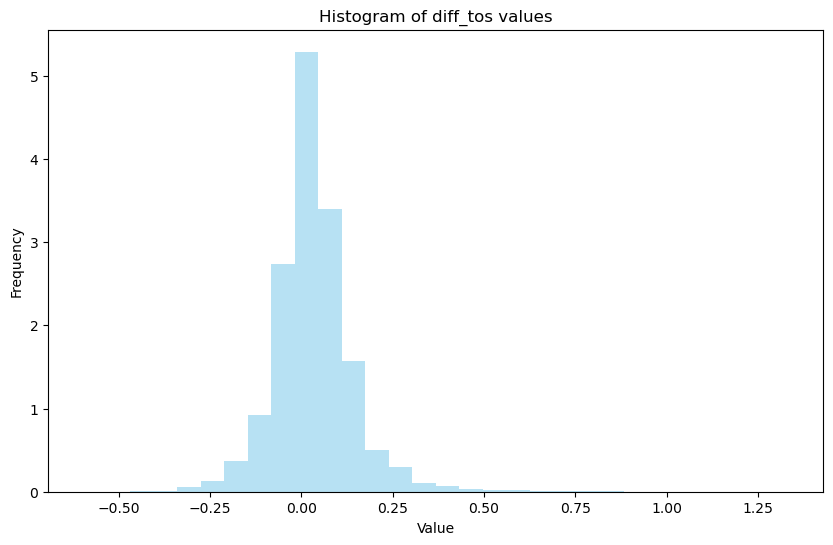

In [31]:
data_flat = diff_tos.values.flatten()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(data_flat, bins=30, density=True, alpha=0.6, color='skyblue')
plt.title("Histogram of diff_tos values")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Perform normality test (Shapiro-Wilk)
shapiro_stat, shapiro_p_value = stats.shapiro(data_flat)
print(f"Shapiro-Wilk Test: W={shapiro_stat:.3f}, p-value={shapiro_p_value:.3f}")



In [33]:
#pos_tos_vals = da_anoms.sel(time=Positive.dropna(dim='time')['time'])
#neg_tos_vals = da_anoms.sel(time=Negative.dropna(dim='time')['time'])
PositivePDO_tos_vals = da_anoms.sel(time=Positive.dropna(dim='time')['time'], method="nearest")
NegativePDO_tos_vals = da_anoms.sel(time=Negative.dropna(dim='time')['time'], method="nearest")


In [34]:
tstat,pval = ttest_ind(PositivePDO_tos_vals, 
                NegativePDO_tos_vals, 
                equal_var = False)

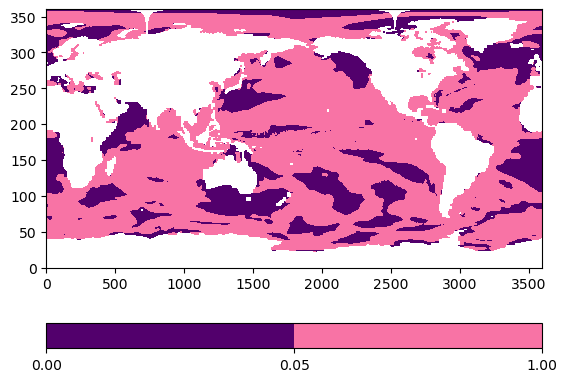

In [35]:
plt.contourf(pval,[0,0.05,1],cmap='RdPu_r') 
plt.colorbar(orientation='horizontal') ;

In [36]:
mask_diff = diff_tos.where(pval <= p)
mask_diff

<xarray.DataArray 'tos' (lat: 361, lon: 3601)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.03986262, 0.0398838 , 0.03990512, ..., 0.03982048, 0.03984154,
        0.03986262],
       [0.04507071, 0.0450867 , 0.04510269, ..., 0.04503889, 0.04505476,
        0.04507071],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9 360.0

Text(0.5, 0.98, 'Composite Precipitation Differences El Nino-Neutral')

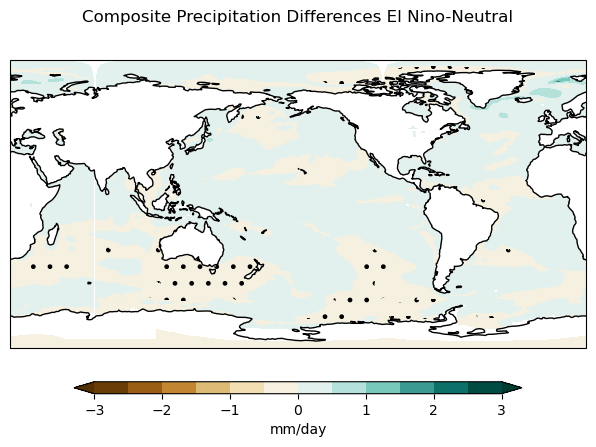

In [37]:
labels=['Positive vs. Negative PDO']
clevs=np.arange(-3,3.5,0.5)
hatch_levs=[0]

# Define the figure and each axis for the 2 rows and 1 columns
fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200.0)})


data=diff_tos

# Add the cyclic point
data,lons=add_cyclic_point(data,coord=diff_tos['lon'])
mask_data,lons=add_cyclic_point(mask_diff,coord=diff_tos['lon'])

# Contour plot
cs=axs.contourf(lons,diff_tos['lat'],data,clevs,
                transform = ccrs.PlateCarree(),
                cmap='BrBG',extend='both')

# Overlay of stippling
ss=axs.contourf(lons,diff_tos['lat'],mask_data,[0,1],
                transform = ccrs.PlateCarree(),colors=['None'],
                hatches=['.',''],extend='both',alpha=0.0)

# Draw the coastines for each subplot
axs.coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.15, 0.18, 0.7, 0.025])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm/day')

# Add a big title at the top
plt.suptitle('Composite Precipitation Differences El Nino-Neutral')

#plt.savefig('stats_ttest.png')